# Hurricane Milton Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
# Load the data
file_path = 'Hurricane_Milton_Plot_Data.csv'  # Ensure this file is in your working directory
data = pd.read_csv(file_path)

# Process datetime and numeric fields
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data['Temp'] = pd.to_numeric(data['Temp'], errors='coerce')
data['Dew'] = pd.to_numeric(data['Dew'], errors='coerce')
data['Wind Speed'] = pd.to_numeric(data['Wind Speed'], errors='coerce')
data['Hi Speed'] = pd.to_numeric(data['Hi Speed'], errors='coerce')
data['Rain Rate'] = pd.to_numeric(data['Rain Rate'], errors='coerce')
data['Bar'] = pd.to_numeric(data['Bar'], errors='coerce')
data.set_index('Datetime', inplace=True)

# Calculate 30-minute pressure tendency
data['Pressure_Tendency_30min'] = data['Bar'].diff(periods=30)
data.reset_index(inplace=True)


C:\Users\Brandan Keen\AppData\Local\Temp\ipykernel_1432\1493877389.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])


In [3]:
# Identify key points
max_temp = data['Temp'].max()
max_temp_time = data.loc[data['Temp'].idxmax(), 'Datetime']
max_rain = data['Rain Rate'].max()
max_rain_time = data.loc[data['Rain Rate'].idxmax(), 'Datetime']
max_gust = data['Hi Speed'].max()
max_gust_time = data.loc[data['Hi Speed'].idxmax(), 'Datetime']
min_press = data['Bar'].min()
min_press_time = data.loc[data['Bar'].idxmin(), 'Datetime']
min_tend = data['Pressure_Tendency_30min'].min()
min_tend_time = data.loc[data['Pressure_Tendency_30min'].idxmin(), 'Datetime']


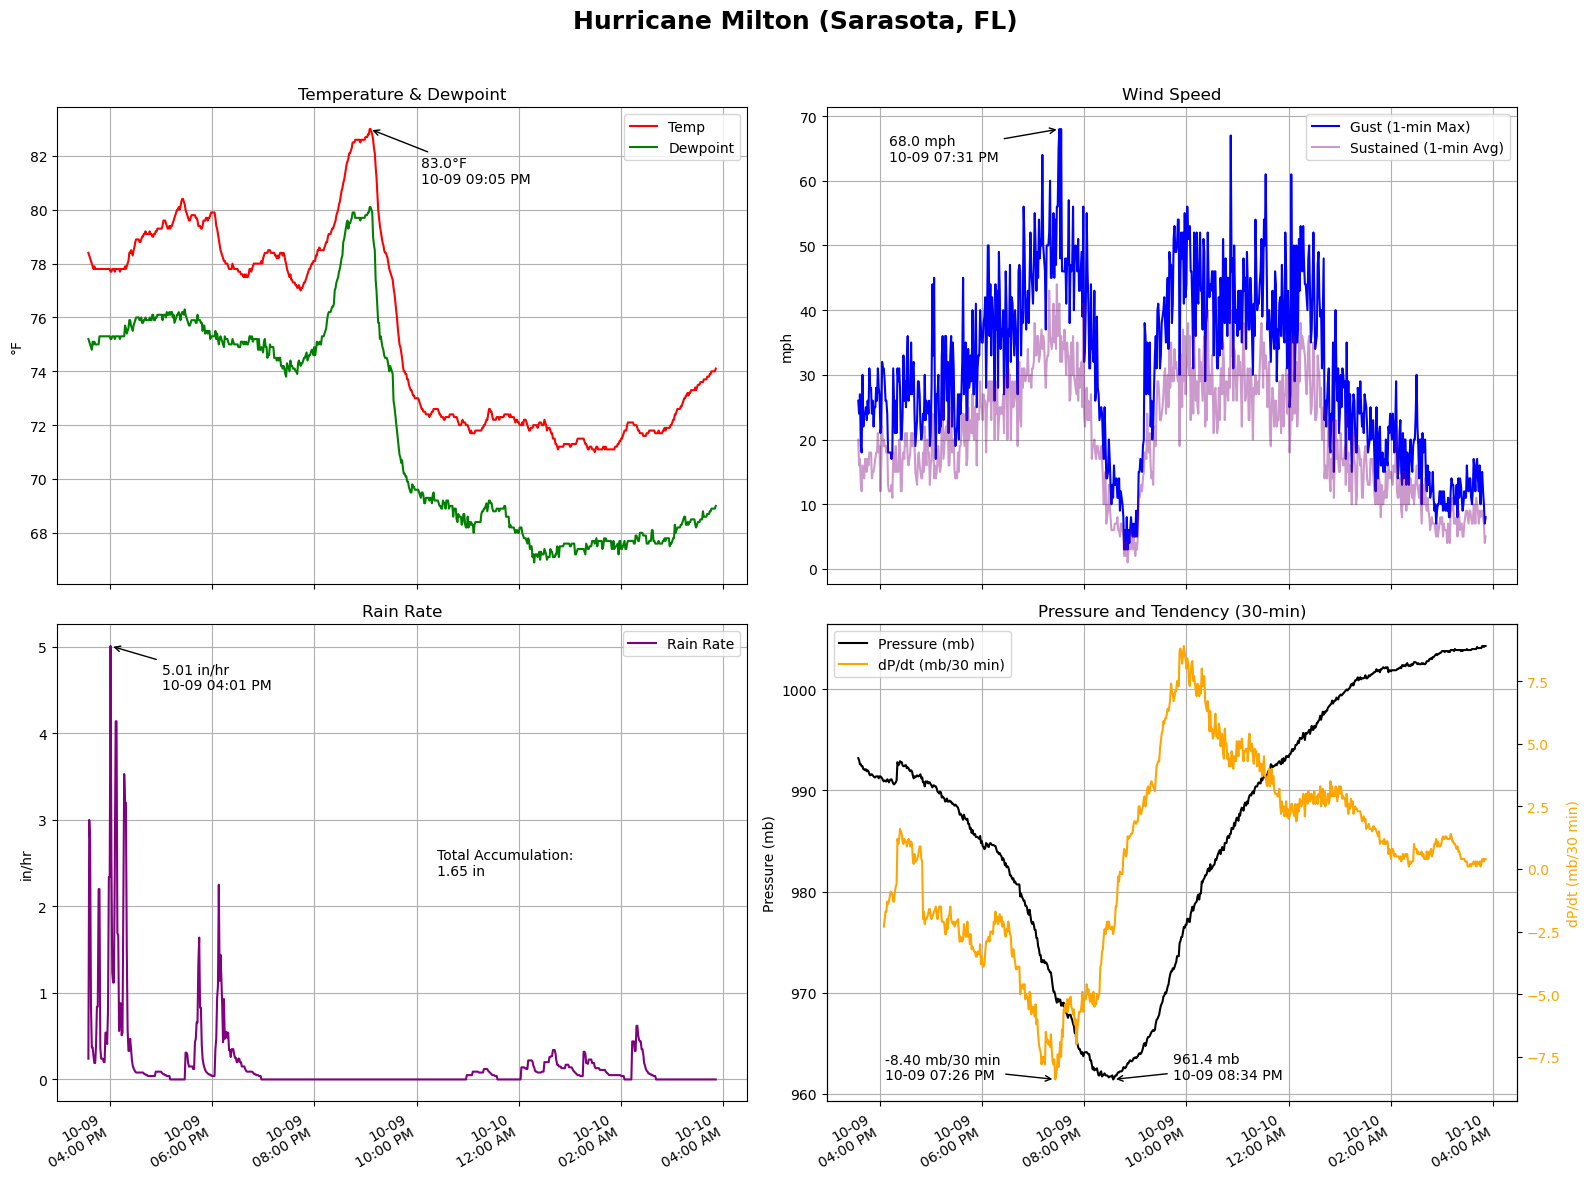

In [4]:
# Plotting
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Temperature & Dewpoint
axs[0, 0].plot(data['Datetime'], data['Temp'], color='red', label='Temp')
axs[0, 0].plot(data['Datetime'], data['Dew'], color='green', label='Dewpoint')
axs[0, 0].annotate(f'{max_temp:.1f}°F\n{max_temp_time:%m-%d %I:%M %p}',
                   xy=(max_temp_time, max_temp),
                   xytext=(max_temp_time + pd.Timedelta(minutes=60), max_temp-2),
                   arrowprops=dict(arrowstyle='->'))
axs[0, 0].set_title('Temperature & Dewpoint')
axs[0, 0].set_ylabel('°F')
axs[0, 0].grid(True)
axs[0, 0].legend(loc='upper right')

# Wind Speed
axs[0, 1].plot(data['Datetime'], data['Hi Speed'], color='blue', label='Gust (1-min Max)')
axs[0, 1].plot(data['Datetime'], data['Wind Speed'], color='purple', alpha=0.4, label='Sustained (1-min Avg)')
axs[0, 1].annotate(f'{max_gust:.1f} mph\n{max_gust_time:%m-%d %I:%M %p}',
                   xy=(max_gust_time, max_gust),
                   xytext=(max_gust_time - pd.Timedelta(minutes=200), max_gust-5),
                   arrowprops=dict(arrowstyle='->'))
axs[0, 1].set_title('Wind Speed')
axs[0, 1].set_ylabel('mph')
axs[0, 1].grid(True)
axs[0, 1].legend(loc='upper right')

# Rain Rate
axs[1, 0].plot(data['Datetime'], data['Rain Rate'], color='purple', label='Rain Rate')
axs[1, 0].annotate(f'{max_rain:.2f} in/hr\n{max_rain_time:%m-%d %I:%M %p}',
                   xy=(max_rain_time, max_rain),
                   xytext=(max_rain_time + pd.Timedelta(minutes=60), max_rain - 0.5),
                   arrowprops=dict(arrowstyle='->'))

# Total rainfall label (bottom right)
total_rain = data['Rain Accum'].dropna().sum()
axs[1, 0].text(0.55, 0.5, f'Total Accumulation:\n{total_rain:.2f} in',
               transform=axs[1, 0].transAxes,
               verticalalignment='center', horizontalalignment='left',
               fontsize=10, color='black')



axs[1, 0].set_title('Rain Rate')
axs[1, 0].set_ylabel('in/hr')
axs[1, 0].grid(True)
axs[1, 0].legend(loc='upper right')




# Pressure and Tendency
ax_pressure = axs[1, 1]
ax_tendency = ax_pressure.twinx()

# Plot pressure and tendency lines
line_pressure, = ax_pressure.plot(data['Datetime'], data['Bar'], color='black', label='Pressure (mb)')
line_tendency, = ax_tendency.plot(data['Datetime'], data['Pressure_Tendency_30min'], color='orange', linestyle='-', label='dP/dt (mb/30 min)')

# Annotate min pressure
ax_pressure.annotate(f'{min_press:.1f} mb\n{min_press_time:%m-%d %I:%M %p}',
                     xy=(min_press_time, min_press),
                     xytext=(min_press_time + pd.Timedelta(minutes=70), min_press),
                     arrowprops=dict(arrowstyle='->'))

# Annotate min tendency
ax_tendency.annotate(f'{min_tend:.2f} mb/30 min\n{min_tend_time:%m-%d %I:%M %p}',
                     xy=(min_tend_time, min_tend),
                     xytext=(min_tend_time - pd.Timedelta(minutes=200), min_tend),
                     arrowprops=dict(arrowstyle='->'))

# Titles and labels
ax_pressure.set_title('Pressure and Tendency (30-min)')
ax_pressure.set_ylabel('Pressure (mb)', color='black')
ax_tendency.set_ylabel('dP/dt (mb/30 min)', color='orange')
ax_tendency.tick_params(axis='y', labelcolor='orange')

ax_pressure.grid(True)

# Add combined legend
lines = [line_pressure, line_tendency]
labels = [line.get_label() for line in lines]
ax_pressure.legend(lines, labels, loc='best')

# Format x-axis for all subplots
for ax in axs.flat:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%I:%M %p'))

fig.suptitle('Hurricane Milton (Sarasota, FL)', fontsize=18, fontweight='bold')
fig.autofmt_xdate()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("Hurricane_Milton_MultiPanel.png", dpi=300, bbox_inches='tight')
plt.show()


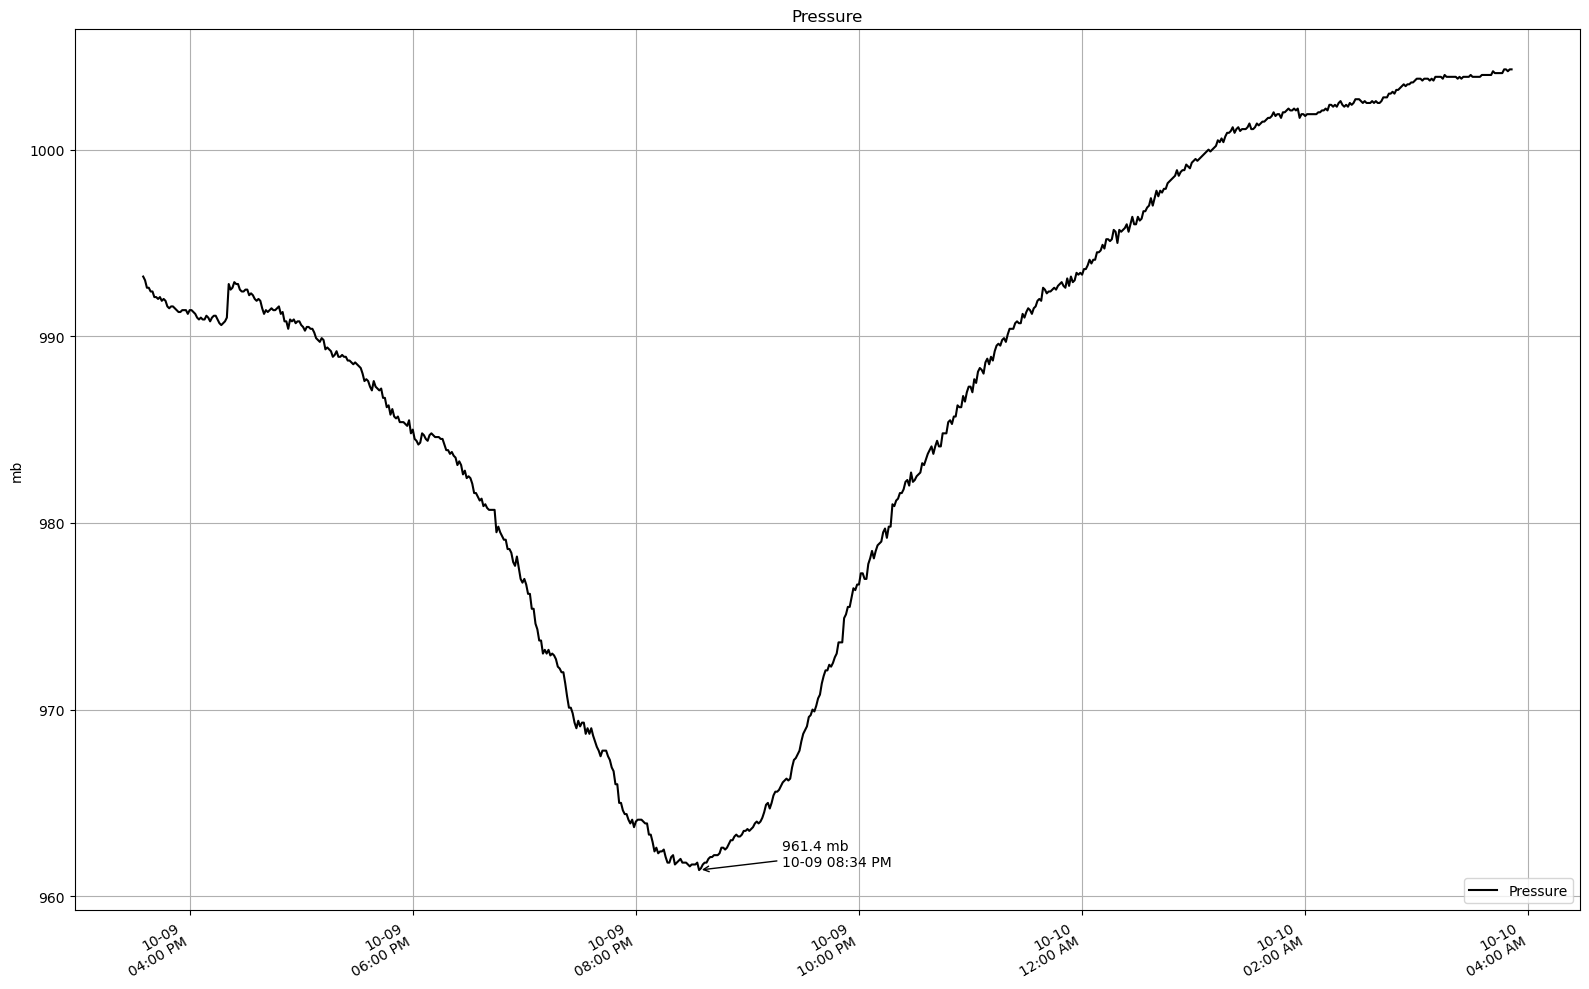

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Load the Milton dataset
df = pd.read_csv("Hurricane_Milton_Plot_Data.csv", parse_dates=['Datetime'])
df.set_index('Datetime', inplace=True)

# === Pressure Plot ===
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10), sharex=True)
ax1.plot(df.index, df['Bar'], color='black', label='Pressure')
ax1.legend(loc='lower right')
ax1.set_title('Pressure')
ax1.set_ylabel('mb')
ax1.grid(True)
ax1.minorticks_off()

min_pressure = df['Bar'].min()
min_time = df['Bar'].idxmin()
ax1.annotate(f'{min_pressure:.1f} mb\n{min_time.strftime("%m-%d %I:%M %p")}',
             xy=(min_time, min_pressure), xytext=(60, 3), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'), color='black')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%I:%M %p'))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("Hurricane_Milton_MSLP.png", dpi=300, bbox_inches='tight')
plt.show()


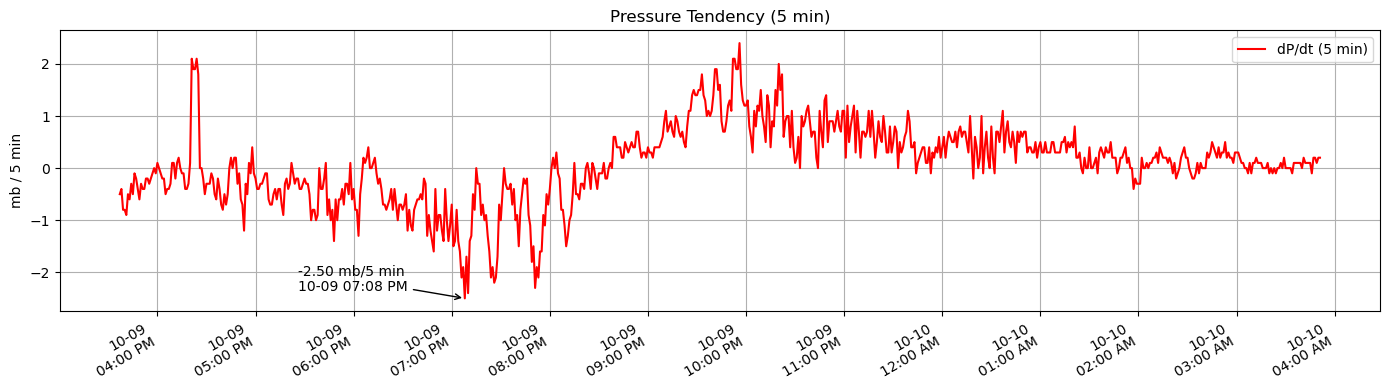

In [6]:
col = df['Pressure_Tendency_5min']
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(col.index, col, linestyle='-', color='red', label='dP/dt (5 min)')

min_val = col.min()
min_time = col.idxmin()
ax.annotate(f'{min_val:.2f} mb/5 min\n{min_time.strftime("%m-%d %I:%M %p")}',
            xy=(min_time, min_val), xytext=(-120, 5), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='black'), color='black')

ax.set_title('Pressure Tendency (5 min)')
ax.set_ylabel('mb / 5 min')
ax.legend(loc='upper right')
ax.grid(True)
ax.minorticks_off()

ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
#ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%I:%M %p'))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("Hurricane_Milton_PTendency_5min.png", dpi=300, bbox_inches='tight')
plt.show()


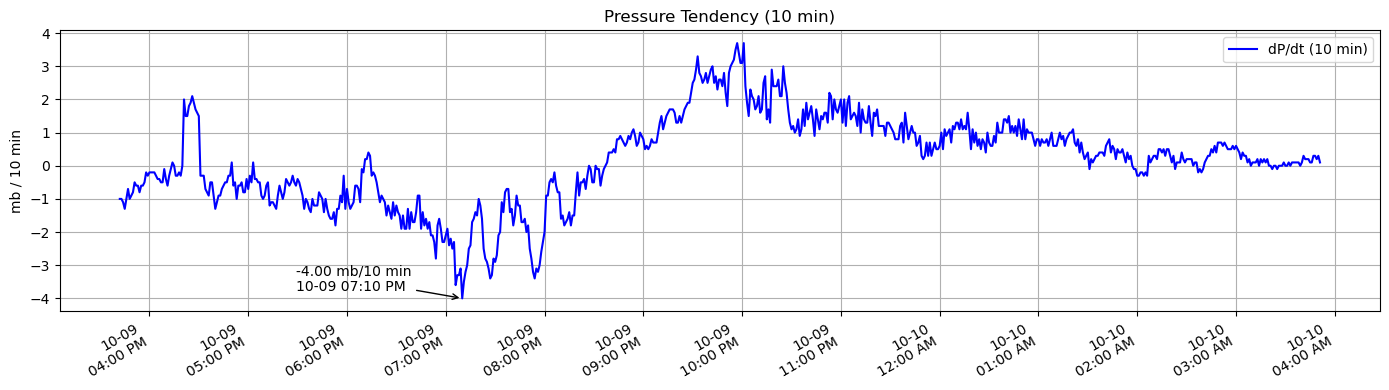

In [7]:
col = df['Pressure_Tendency_10min']
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(col.index, col, linestyle='-', color='blue', label='dP/dt (10 min)')

min_val = col.min()
min_time = col.idxmin()
ax.annotate(f'{min_val:.2f} mb/10 min\n{min_time.strftime("%m-%d %I:%M %p")}',
            xy=(min_time, min_val), xytext=(-120, 5), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='black'), color='black')

ax.set_title('Pressure Tendency (10 min)')
ax.set_ylabel('mb / 10 min')
ax.legend(loc='upper right')
ax.grid(True)
ax.minorticks_off()

ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
#ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%I:%M %p'))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("Hurricane_Milton_PTendency_10min.png", dpi=300, bbox_inches='tight')
plt.show()


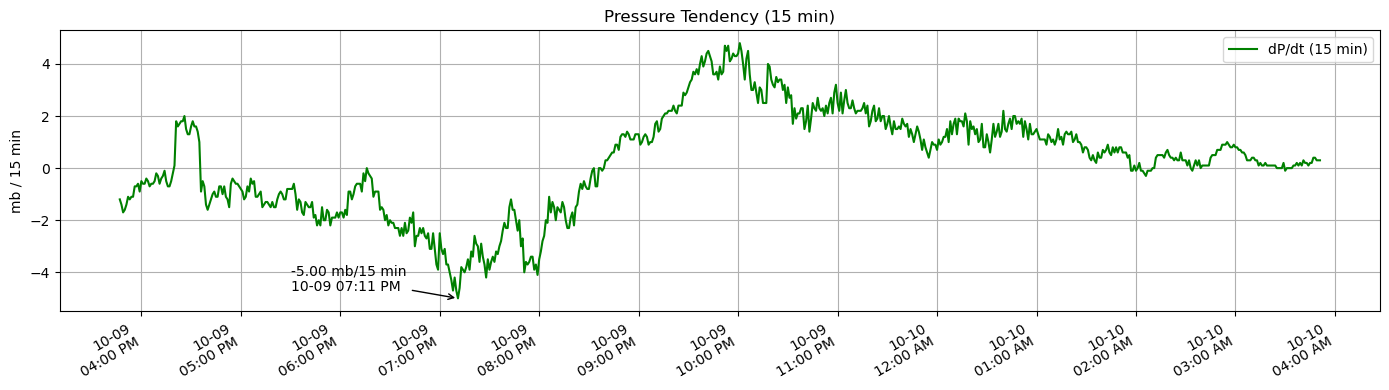

In [8]:
col = df['Pressure_Tendency_15min']
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(col.index, col, linestyle='-', color='green', label='dP/dt (15 min)')

min_val = col.min()
min_time = col.idxmin()
ax.annotate(f'{min_val:.2f} mb/15 min\n{min_time.strftime("%m-%d %I:%M %p")}',
            xy=(min_time, min_val), xytext=(-120, 5), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='black'), color='black')

ax.set_title('Pressure Tendency (15 min)')
ax.set_ylabel('mb / 15 min')
ax.legend(loc='upper right')
ax.grid(True)
ax.minorticks_off()

ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
#ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%I:%M %p'))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("Hurricane_Milton_PTendency_15min.png", dpi=300, bbox_inches='tight')
plt.show()


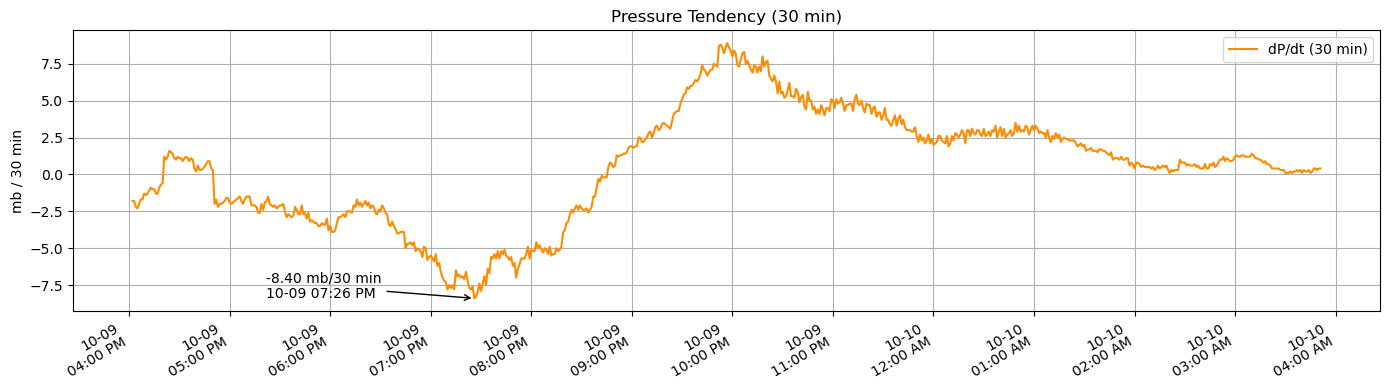

In [9]:
col = df['Pressure_Tendency_30min']
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(col.index, col, linestyle='-', color='darkorange', label='dP/dt (30 min)')

min_val = col.min()
min_time = col.idxmin()
ax.annotate(f'{min_val:.2f} mb/30 min\n{min_time.strftime("%m-%d %I:%M %p")}',
            xy=(min_time, min_val), xytext=(-150, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='black'), color='black')

ax.set_title('Pressure Tendency (30 min)')
ax.set_ylabel('mb / 30 min')
ax.legend(loc='upper right')
ax.grid(True)
ax.minorticks_off()

ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
#ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%I:%M %p'))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("Hurricane_Milton_PTendency_30min.png", dpi=300, bbox_inches='tight')
plt.show()


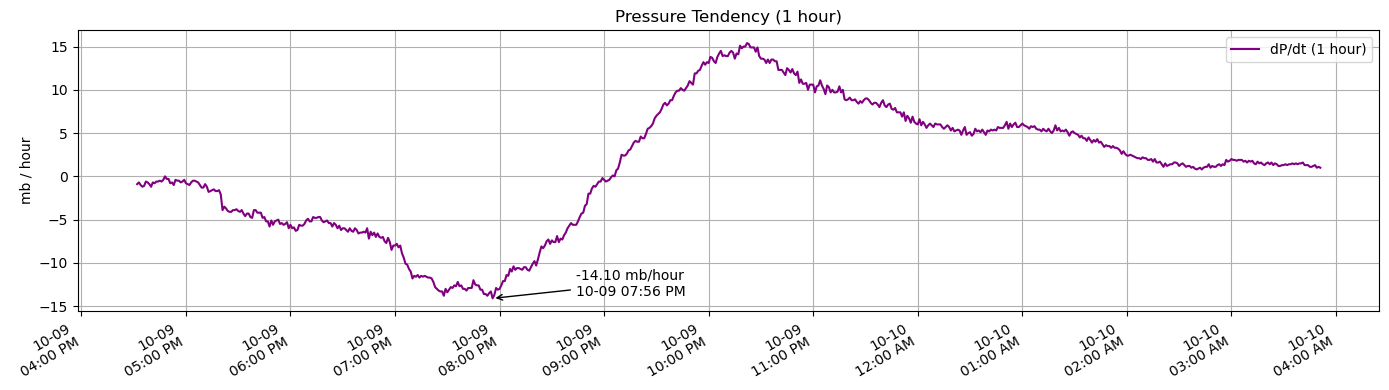

In [10]:
col = df['Pressure_Tendency_60min']
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(col.index, col, linestyle='-', color='purple', label='dP/dt (1 hour)')

min_val = col.min()
min_time = col.idxmin()
ax.annotate(f'{min_val:.2f} mb/hour\n{min_time.strftime("%m-%d %I:%M %p")}',
            xy=(min_time, min_val), xytext=(60, 2), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='black'), color='black')

ax.set_title('Pressure Tendency (1 hour)')
ax.set_ylabel('mb / hour')
ax.legend(loc='upper right')
ax.minorticks_off()
ax.grid(True)


ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
#ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%I:%M %p'))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("Hurricane_Milton_PTendency_1hour.png", dpi=300, bbox_inches='tight')
plt.show()


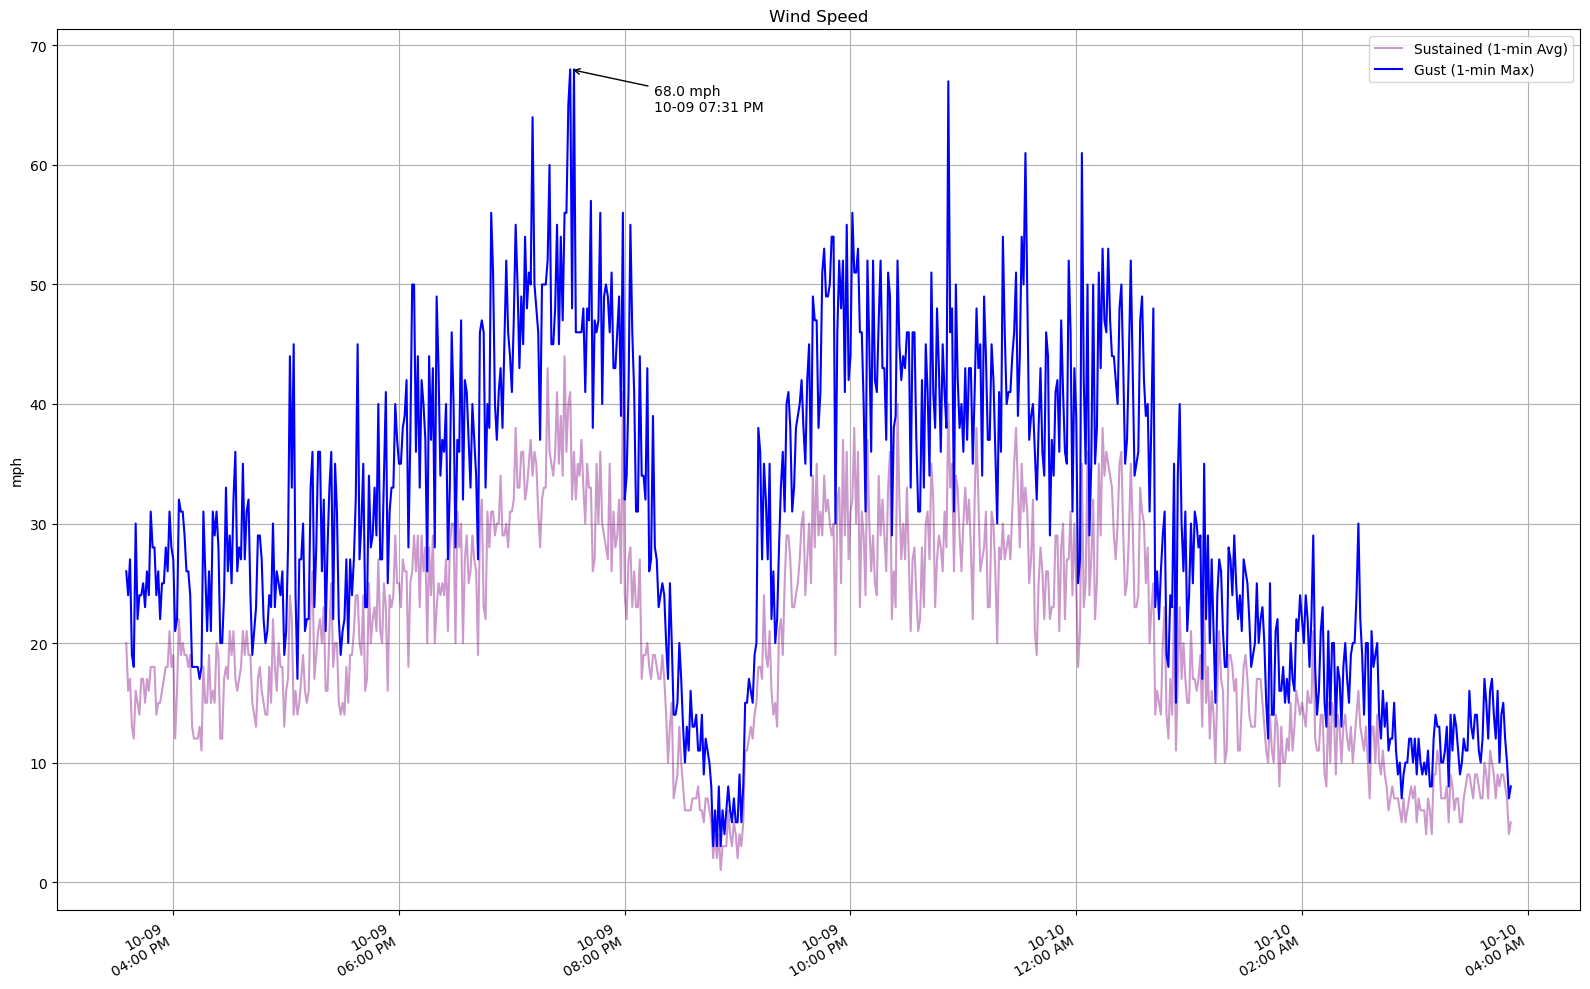

In [11]:
# Load Milton data
df = pd.read_csv("Hurricane_Milton_Plot_Data.csv", parse_dates=['Datetime'])
df.set_index('Datetime', inplace=True)

# Plot wind data
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(df.index, df['Wind Speed'], color='purple', alpha=0.4, label='Sustained (1-min Avg)')
ax.plot(df.index, df['Hi Speed'], color='blue', label='Gust (1-min Max)')

# Annotate max gust
max_gust = df['Hi Speed'].max()
max_time = df['Hi Speed'].idxmax()
ax.annotate(f'{max_gust:.1f} mph\n{max_time.strftime("%m-%d %I:%M %p")}',
            xy=(max_time, max_gust), xytext=(60, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='black'), color='black')

ax.set_title('Wind Speed')
ax.set_ylabel('mph')
ax.legend(loc='upper right')
ax.grid(True)
ax.minorticks_off()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%I:%M %p'))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("Hurricane_Milton_WindSpeed.png", dpi=300, bbox_inches='tight')
plt.show()


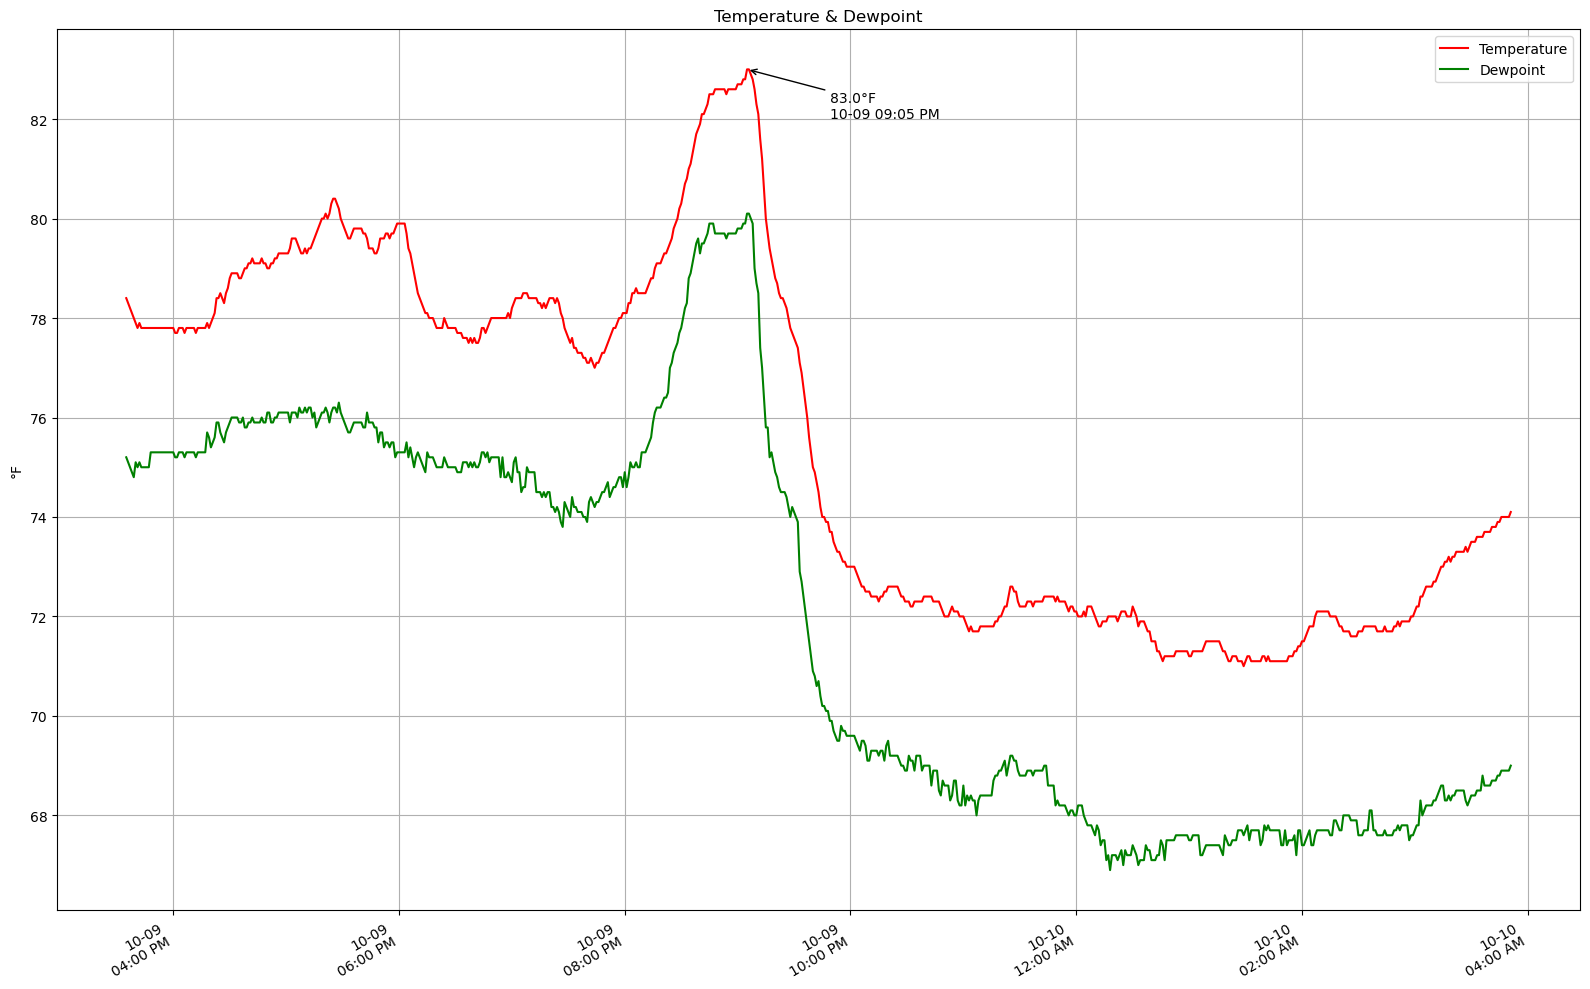

In [12]:
df = pd.read_csv("Hurricane_Milton_Plot_Data.csv", parse_dates=['Datetime'])
df.set_index('Datetime', inplace=True)

fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(df.index, df['Temp'], color='red', label='Temperature')
ax.plot(df.index, df['Dew'], color='green', label='Dewpoint')

max_temp = df['Temp'].max()
max_temp_time = df['Temp'].idxmax()
ax.annotate(f'{max_temp:.1f}°F\n{max_temp_time.strftime("%m-%d %I:%M %p")}',
            xy=(max_temp_time, max_temp), xytext=(60, -35), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='black'), color='black')

ax.set_title('Temperature & Dewpoint')
ax.set_ylabel('°F')
ax.legend(loc='upper right')
ax.grid(True)
ax.minorticks_off()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%I:%M %p'))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("Hurricane_Milton_Temp_Dew.png", dpi=300, bbox_inches='tight')
plt.show()


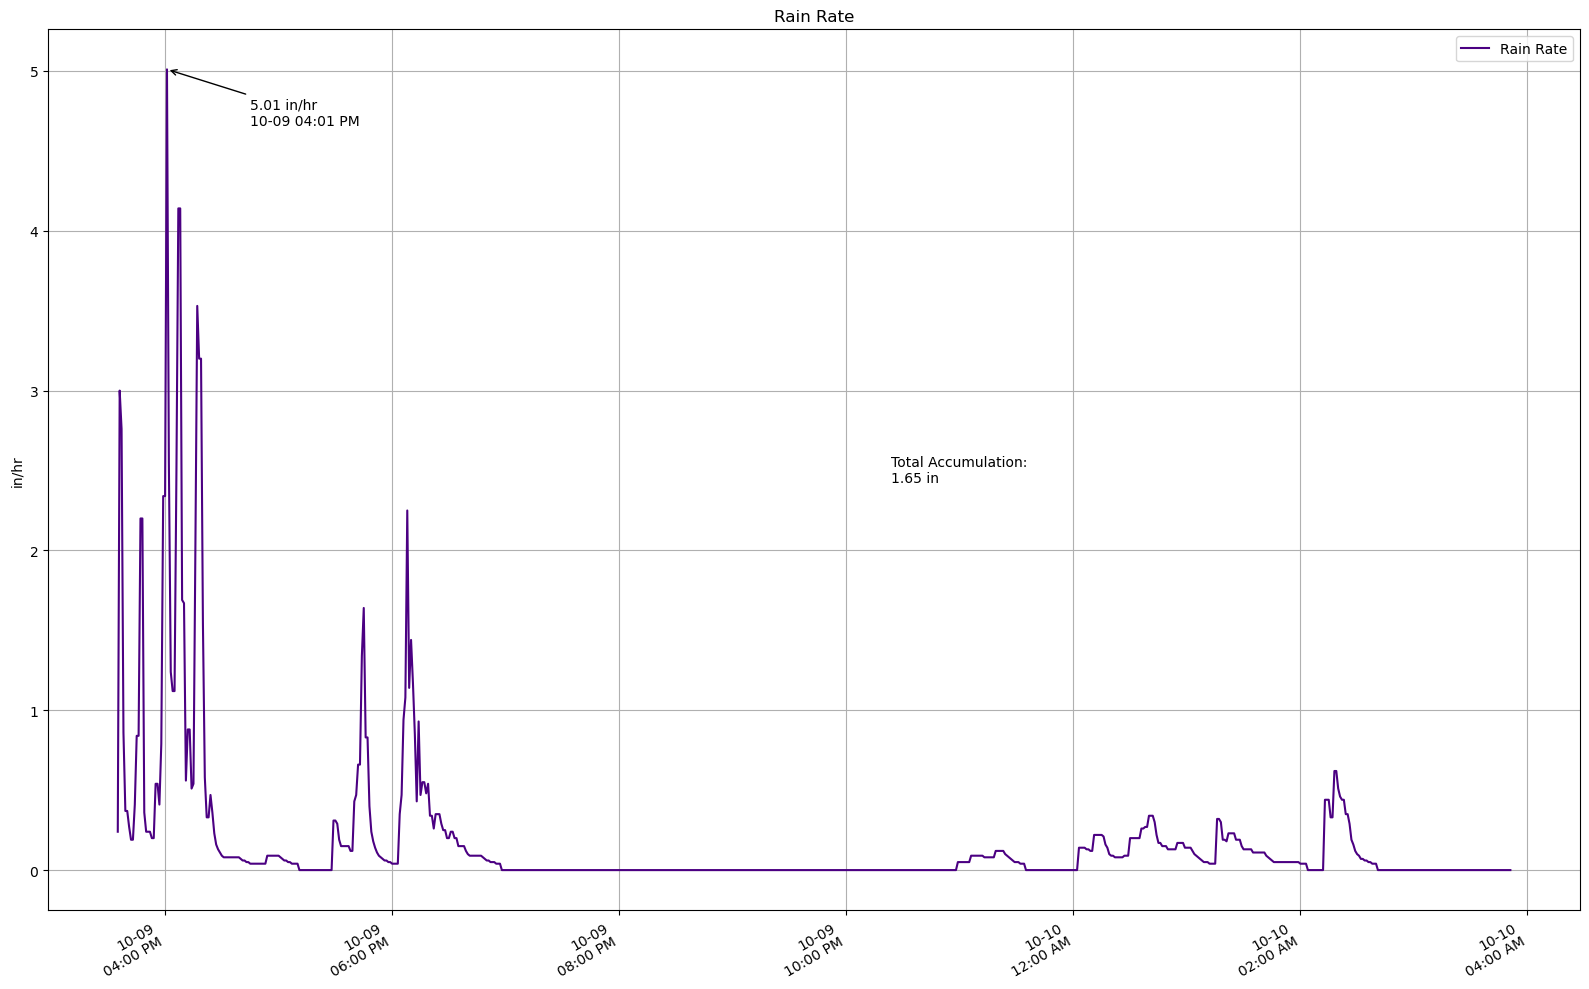

In [13]:
df = pd.read_csv("Hurricane_Milton_Plot_Data.csv", parse_dates=['Datetime'])
df.set_index('Datetime', inplace=True)

fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(df.index, df['Rain Rate'], color='indigo', label='Rain Rate')

max_rain = df['Rain Rate'].max()
max_rain_time = df['Rain Rate'].idxmax()
ax.annotate(f'{max_rain:.2f} in/hr\n{max_rain_time.strftime("%m-%d %I:%M %p")}',
            xy=(max_rain_time, max_rain), xytext=(60, -40), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='black'), color='black')

total_accum = df['Rain Accum'].sum()
ax.text(0.55, 0.5, f'Total Accumulation:\n{total_accum:.2f} in',
        transform=ax.transAxes, verticalalignment='center', horizontalalignment='left',
        fontsize=10, color='black')

ax.set_title('Rain Rate')
ax.set_ylabel('in/hr')
ax.legend(loc='upper right')
ax.grid(True)
ax.minorticks_off()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%I:%M %p'))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("Hurricane_Milton_RainRate.png", dpi=300, bbox_inches='tight')
plt.show()
